# Week two Refining your data 

In [23]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import ipaddress
import json

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize'] = (10,5)



## Replace 'your_file.csv' with the path to your CSV file

In [24]:
# Cell 2 - load csv
csv_file = 'cowrie_2024-02-07.csv'   # <-- change if your file is named differently
df = pd.read_csv(csv_file)

print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())
# quick peek for screenshot
display(df.head(8))



Loaded rows: 2472
Columns: ['timestamp', 'eventid', 'src_ip', 'username', 'password', 'sensor', 'message']


,timestamp,eventid,src_ip,username,password,sensor,message
0,2024-02-07T00:48:24.402171Z,cowrie.session.connect,75.119.144.68,NaN,NaN,d647d7cf7742,New connection: 75.119.144.68:56824 (172.17.0....
1,2024-02-07T00:48:27.822160Z,cowrie.session.closed,75.119.144.68,NaN,NaN,d647d7cf7742,Connection lost after 3 seconds
2,2024-02-07T00:48:27.916707Z,cowrie.session.connect,75.119.144.68,NaN,NaN,d647d7cf7742,New connection: 75.119.144.68:56828 (172.17.0....
3,2024-02-07T00:48:30.534384Z,cowrie.client.version,75.119.144.68,NaN,NaN,d647d7cf7742,Remote SSH version: SSH-2.0-Go
4,2024-02-07T00:48:30.535620Z,cowrie.client.kex,75.119.144.68,NaN,NaN,d647d7cf7742,SSH client hassh fingerprint: 98f63c4d9c87edbd...
5,2024-02-07T00:48:56.141345Z,cowrie.login.success,75.119.144.68,root,------fuck------,d647d7cf7742,login attempt [root/------fuck------] succeeded
6,2024-02-07T00:49:28.574598Z,cowrie.session.params,75.119.144.68,NaN,NaN,d647d7cf7742,[]
7,2024-02-07T00:49:28.575549Z,cowrie.command.input,75.119.144.68,NaN,NaN,d647d7cf7742,CMD: uname -s -m


## Identify categorical columns (object type)

In [25]:
# Cell 3 - timestamp normalization & initial cleaning
# Many Cowrie timestamps are ISO8601 like: 2024-02-07T00:48:24.402171Z
def parse_iso_ts(s):
    try:
        return pd.to_datetime(s, utc=True)
    except Exception:
        return pd.NaT

# Ensure timestamp column exists
if 'timestamp' not in df.columns:
    raise RuntimeError("Expected 'timestamp' column in CSV")

df['timestamp_parsed'] = df['timestamp'].apply(parse_iso_ts)
print("Parsed timestamps: non-null count =", df['timestamp_parsed'].notna().sum())

# Drop rows with missing timestamps since time context is required for our temporal features
before = len(df)
df = df.dropna(subset=['timestamp_parsed']).reset_index(drop=True)
after = len(df)
print(f"Dropped {before-after} rows without valid timestamp (kept {after}).")

# lowercase eventid for consistency
if 'eventid' in df.columns:
    df['eventid'] = df['eventid'].astype(str).str.strip().str.lower()

# ensure src_ip exists
if 'src_ip' not in df.columns:
    # try to extract IP from message if not present
    ip_re = re.compile(r'((?:\d{1,3}\.){3}\d{1,3})')
    df['src_ip'] = df['message'].astype(str).apply(lambda m: (ip_re.search(m).group(1) if ip_re.search(m) else np.nan))

# validate IPs and set invalid to NaN
def valid_ip(s):
    try:
        if pd.isna(s): 
            return False
        ipaddress.ip_address(str(s))
        return True
    except Exception:
        return False

df['src_ip'] = df['src_ip'].where(df['src_ip'].apply(valid_ip), np.nan)

# quick counts
print("Unique src_ip count:", df['src_ip'].nunique(dropna=True))
print("Unique eventid examples:", df['eventid'].unique()[:12])


Parsed timestamps: non-null count = 2472
Dropped 0 rows without valid timestamp (kept 2472).
Unique src_ip count: 24
Unique eventid examples: ['cowrie.session.connect' 'cowrie.session.closed' 'cowrie.client.version'
 'cowrie.client.kex' 'cowrie.login.success' 'cowrie.session.params'
 'cowrie.command.input' 'cowrie.log.closed' 'cowrie.direct-tcpip.request'
 'cowrie.direct-tcpip.data' 'cowrie.login.failed']


##  Create a dictionary to hold DataFrames for each category

In [26]:
# Cell 4 - parse message for username/password/session/ssh-version
# Patterns commonly in the Cowrie message field:
# - "login attempt [user/pass] failed" or "login attempt [user/pass] succeeded"
# - "New connection: <ip>:<port> (..."
# - "SSH client hassh fingerprint: <fingerprint>"
# - "Remote SSH version: SSH-2.0-OpenSSH_7.4" or sometimes binary blobs

# regex patterns
login_re = re.compile(r'login attempt \[(?P<user>[^/\]]+?)/(?P<pass>[^\]]+?)\] (?P<result>failed|succeeded)', re.IGNORECASE)
newconn_re = re.compile(r'new connection: (?P<src>[\d\.]+):(?P<src_port>\d+)', re.IGNORECASE)
sshver_re = re.compile(r'remote ssh version:\s*(?P<sshver>[^\]]+)', re.IGNORECASE)
session_re = re.compile(r'\[session:\s*(?P<session>[0-9a-fA-F]+)\]', re.IGNORECASE)

def extract_fields(row):
    m_login = login_re.search(str(row['message']))
    m_conn = newconn_re.search(str(row['message']))
    m_ssh = sshver_re.search(str(row['message']))
    m_sess = session_re.search(str(row['message']))
    return pd.Series({
        'parsed_user': m_login.group('user') if m_login else np.nan,
        'parsed_password': m_login.group('pass') if m_login else np.nan,
        'login_result': (m_login.group('result').lower() if m_login else np.nan),
        'msg_newconn_ip': m_conn.group('src') if m_conn else np.nan,
        'msg_newconn_port': (int(m_conn.group('src_port')) if m_conn else np.nan),
        'ssh_version': m_ssh.group('sshver').strip() if m_ssh else np.nan,
        'session_id': m_sess.group('session') if m_sess else np.nan
    })

parsed_cols = df.apply(extract_fields, axis=1)
df = pd.concat([df, parsed_cols], axis=1)

# Fill src_ip from message new connection IP when src_ip missing
df['src_ip'] = df['src_ip'].fillna(df['msg_newconn_ip'])

# Standardize login_result values
df['login_result'] = df['login_result'].where(df['login_result'].notna(), np.nan)

# Show cleaned head for screenshot (this covers "screenshot of code execution")
print("Cleaned and parsed DataFrame (head):")
display(df[['timestamp_parsed','eventid','src_ip','parsed_user','parsed_password','login_result','ssh_version','session_id','message']].head(12))


Cleaned and parsed DataFrame (head):


,timestamp_parsed,eventid,src_ip,parsed_user,parsed_password,login_result,ssh_version,session_id,message
0,2024-02-07 00:48:24.402171+00:00,cowrie.session.connect,75.119.144.68,NaN,NaN,NaN,NaN,5ee36a44ad01,New connection: 75.119.144.68:56824 (172.17.0....
1,2024-02-07 00:48:27.822160+00:00,cowrie.session.closed,75.119.144.68,NaN,NaN,NaN,NaN,NaN,Connection lost after 3 seconds
2,2024-02-07 00:48:27.916707+00:00,cowrie.session.connect,75.119.144.68,NaN,NaN,NaN,NaN,cec4878611ec,New connection: 75.119.144.68:56828 (172.17.0....
3,2024-02-07 00:48:30.534384+00:00,cowrie.client.version,75.119.144.68,NaN,NaN,NaN,SSH-2.0-Go,NaN,Remote SSH version: SSH-2.0-Go
4,2024-02-07 00:48:30.535620+00:00,cowrie.client.kex,75.119.144.68,NaN,NaN,NaN,NaN,NaN,SSH client hassh fingerprint: 98f63c4d9c87edbd...
5,2024-02-07 00:48:56.141345+00:00,cowrie.login.success,75.119.144.68,root,------fuck------,succeeded,NaN,NaN,login attempt [root/------fuck------] succeeded
6,2024-02-07 00:49:28.574598+00:00,cowrie.session.params,75.119.144.68,NaN,NaN,NaN,NaN,NaN,[]
7,2024-02-07 00:49:28.575549+00:00,cowrie.command.input,75.119.144.68,NaN,NaN,NaN,NaN,NaN,CMD: uname -s -m
8,2024-02-07 00:49:33.318910+00:00,cowrie.log.closed,75.119.144.68,NaN,NaN,NaN,NaN,NaN,Closing TTY Log: var/lib/cowrie/tty/6fa4c8ac58...
9,2024-02-07 00:49:33.320167+00:00,cowrie.session.closed,75.119.144.68,NaN,NaN,NaN,NaN,NaN,Connection lost after 65 seconds


In [27]:
# Cell 5 - create feature indicators & print selection (these are the three features we'll submit)
# Feature A: Frequency of NEW CONNECTIONS per src_ip (count of cowrie.session.connect events) -> indicates scanning/volume
# Feature B: Login success/failure counts per src_ip and per username -> indicates brute-force and possible compromise
# Feature C: Distribution of SSH client versions (ssh_version) per src_ip -> fingerprint/version anomalies may indicate unusual clients or scanning tools

# create boolean columns
df['is_new_connection'] = df['eventid'].str.contains('session.connect', na=False)
df['is_login_failed'] = df['eventid'].str.contains('login.failed', na=False)
df['is_login_success'] = df['eventid'].str.contains('login.success', na=False)

print("Selected Parsing Items (to include in report):")
print("1) new_connection_count_per_src_ip  (counts of 'cowrie.session.connect')  -> detects scan/volume anomalies")
print("2) login_failed_count / login_success_count  (per src_ip and per username) -> detects brute-force and credential compromise indicators")
print("3) ssh_version_distribution  (ssh versions per src_ip, and rare/unknown versions flagged) -> detects unusual clients/scanners\n")


Selected Parsing Items (to include in report):
1) new_connection_count_per_src_ip  (counts of 'cowrie.session.connect')  -> detects scan/volume anomalies
2) login_failed_count / login_success_count  (per src_ip and per username) -> detects brute-force and credential compromise indicators
3) ssh_version_distribution  (ssh versions per src_ip, and rare/unknown versions flagged) -> detects unusual clients/scanners



In [28]:
# Cell 6 - aggregations for features

# ensure timestamp is timezone-aware/datetime
df['ts_utc'] = pd.to_datetime(df['timestamp_parsed'], utc=True)

# per-IP aggregation
ip_agg = df.groupby('src_ip').agg(
    total_events = ('eventid','count'),
    newconn_count = ('is_new_connection','sum'),
    login_failed_count = ('is_login_failed','sum'),
    login_success_count = ('is_login_success','sum'),
    unique_users = ('parsed_user', lambda s: s.dropna().nunique())
).reset_index()

# derived rates
ip_agg['failure_rate'] = ip_agg['login_failed_count'] / ip_agg['total_events']
ip_agg['success_rate'] = ip_agg['login_success_count'] / ip_agg['total_events']

# ssh version distribution per ip (we'll compute top ssh version and # distinct versions)
ssh_by_ip = df.dropna(subset=['ssh_version']).groupby('src_ip')['ssh_version'].agg(lambda s: s.value_counts().index[0] if len(s)>0 else np.nan).rename('top_ssh_version').reset_index()
ssh_count_by_ip = df.dropna(subset=['ssh_version']).groupby('src_ip')['ssh_version'].nunique().rename('distinct_ssh_versions').reset_index()

# merge ssh aggregates into ip_agg
ip_agg = ip_agg.merge(ssh_by_ip, on='src_ip', how='left').merge(ssh_count_by_ip, on='src_ip', how='left')

# sort by newconn_count or login_failed_count for risk
ip_agg = ip_agg.sort_values(by=['login_failed_count','newconn_count'], ascending=False).reset_index(drop=True)

print("Per-IP feature table (first 12 rows) — use this for your screenshot / feature CSV:")
display(ip_agg.head(12))

# per-user aggregation (useful for report and appendices)
user_agg = df.groupby('parsed_user').agg(
    total_attempts=('eventid','count'),
    failed=('is_login_failed','sum'),
    success=('is_login_success','sum'),
).reset_index().sort_values(by='failed', ascending=False)

print("\nPer-username sample (top 12 by failed attempts):")
display(user_agg.head(12))


Per-IP feature table (first 12 rows) — use this for your screenshot / feature CSV:


,src_ip,total_events,newconn_count,login_failed_count,login_success_count,unique_users,failure_rate,success_rate,top_ssh_version,distinct_ssh_versions
0,138.197.64.59,2114,400,360,39,172,0.170293,0.018448,SSH-2.0-Go,1.0
1,85.209.11.227,68,11,1,9,2,0.014706,0.132353,SSH-2.0-Go,1.0
2,193.201.9.104,175,25,0,25,1,0.000000,0.142857,SSH-2.0-Go,1.0
3,172.105.128.11,25,7,0,0,0,0.000000,0.000000,SSH-2.0-Go,2.0
4,185.233.19.141,10,4,0,0,0,0.000000,0.000000,SSH-2.0-Go,1.0
5,45.79.168.172,8,4,0,0,0,0.000000,0.000000,NaN,NaN
6,152.32.183.27,10,3,0,0,0,0.000000,0.000000,SSH-2.0-OpenSSH_7.4,1.0
7,167.248.133.38,6,2,0,0,0,0.000000,0.000000,SSH-2.0-Go,1.0
8,167.94.145.53,6,2,0,0,0,0.000000,0.000000,SSH-2.0-Go,1.0
9,192.155.88.231,4,2,0,0,0,0.000000,0.000000,NaN,NaN



Per-username sample (top 12 by failed attempts):


,parsed_user,total_attempts,failed,success
105,oracle,16,16,0
8,admin,10,10,0
14,airflow,10,10,0
160,ubuntu,10,10,0
161,user,9,9,0
120,postgres,8,8,0
128,regix,8,8,0
78,ingres,8,8,0
60,ftpadmin,6,6,0
68,grid,6,6,0


In [29]:
# Cell 7 - normalization and exports
feature_cols = ['total_events','newconn_count','login_failed_count','login_success_count','unique_users','failure_rate','success_rate','distinct_ssh_versions']
for c in feature_cols:
    if c not in ip_agg.columns:
        ip_agg[c] = 0

# simple min-max scaling
scaled = ip_agg.copy()
for col in ['total_events','newconn_count','login_failed_count','login_success_count','unique_users','distinct_ssh_versions','failure_rate','success_rate']:
    mn = scaled[col].min()
    mx = scaled[col].max()
    if pd.isna(mn) or pd.isna(mx) or mx==mn:
        scaled[col + '_scaled'] = 0.0
    else:
        scaled[col + '_scaled'] = (scaled[col] - mn) / (mx - mn)

# final features for model (scaled)
final_features = scaled[['src_ip'] + [col for col in scaled.columns if col.endswith('_scaled')]].copy()
final_features = final_features.rename(columns={'src_ip':'ip'})

# Save outputs
ip_agg.to_csv('ids_week2_ip_aggregates.csv', index=False)
final_features.to_csv('ids_week2_features_scaled_by_ip.csv', index=False)
df.to_csv('ids_week2_parsed_cleaned.csv', index=False)

print("Exported: ids_week2_ip_aggregates.csv, ids_week2_features_scaled_by_ip.csv, ids_week2_parsed_cleaned.csv")
print("Feature table saved (first 12 rows):")
display(final_features.head(12))


Exported: ids_week2_ip_aggregates.csv, ids_week2_features_scaled_by_ip.csv, ids_week2_parsed_cleaned.csv
Feature table saved (first 12 rows):


,ip,total_events_scaled,newconn_count_scaled,login_failed_count_scaled,login_success_count_scaled,unique_users_scaled,distinct_ssh_versions_scaled,failure_rate_scaled,success_rate_scaled
0,138.197.64.59,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.129139
1,85.209.11.227,0.031250,0.025063,0.002778,0.230769,0.011628,0.0,0.086356,0.926471
2,193.201.9.104,0.081913,0.060150,0.000000,0.641026,0.005814,0.0,0.000000,1.000000
3,172.105.128.11,0.010890,0.015038,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
4,185.233.19.141,0.003788,0.007519,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,45.79.168.172,0.002841,0.007519,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
6,152.32.183.27,0.003788,0.005013,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,167.248.133.38,0.001894,0.002506,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,167.94.145.53,0.001894,0.002506,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,192.155.88.231,0.000947,0.002506,0.000000,0.000000,0.000000,NaN,0.000000,0.000000


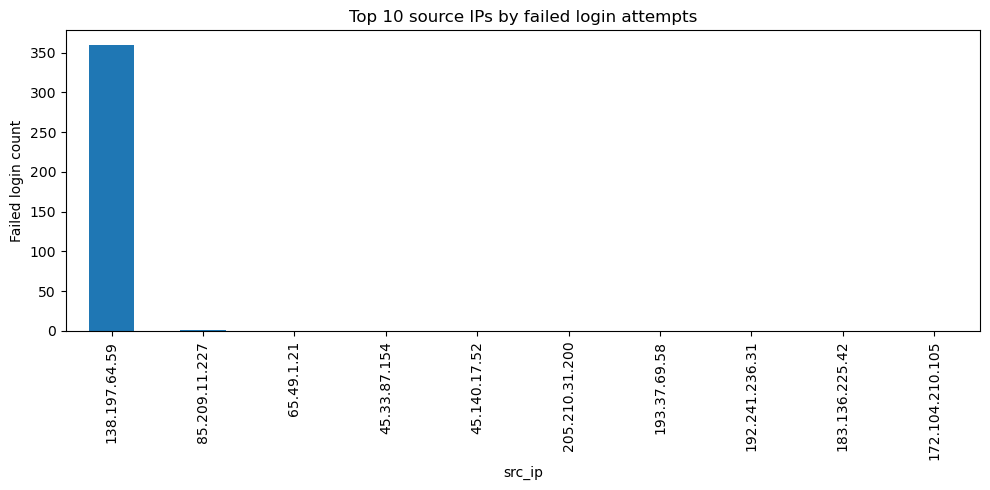

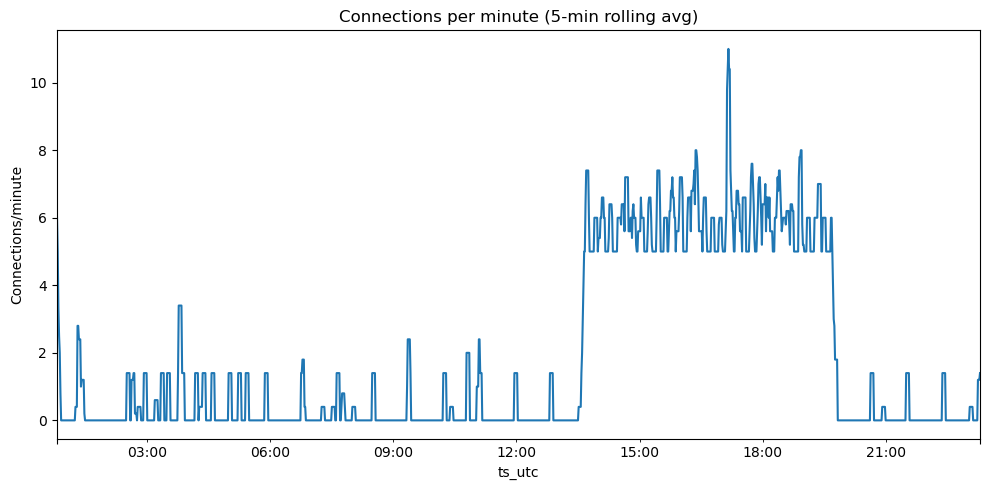

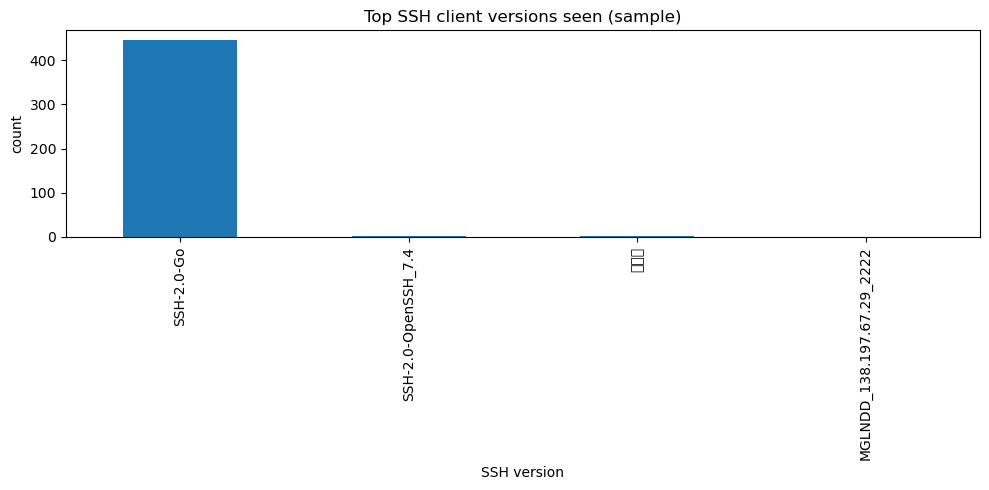

In [30]:
# Cell 8 - plots (use these for screenshot)
# 1. Top 10 IPs by failed login attempts
top_failed = ip_agg.sort_values('login_failed_count', ascending=False).head(10).set_index('src_ip')
ax = top_failed['login_failed_count'].plot(kind='bar', title='Top 10 source IPs by failed login attempts')
ax.set_xlabel('src_ip')
ax.set_ylabel('Failed login count')
plt.tight_layout()
plt.show()

# 2. Connection volume over time (global)
df.set_index('ts_utc', inplace=False)
conn_per_min = df.resample('1T', on='ts_utc').size().rename('connections_per_minute').reset_index()
ax = conn_per_min.set_index('ts_utc')['connections_per_minute'].rolling(5, min_periods=1).mean().plot(title='Connections per minute (5-min rolling avg)')
ax.set_ylabel('Connections/minute')
plt.tight_layout()
plt.show()

# 3. SSH version counts (top 12)
ssh_counts = df['ssh_version'].value_counts().head(12)
if len(ssh_counts) > 0:
    ssh_counts.plot(kind='bar', title='Top SSH client versions seen (sample)')
    plt.xlabel('SSH version')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()
else:
    print("No SSH version strings found in this dataset to plot.")


In [31]:
# Cell 9 - cleaning summary (print and save as JSON to include in Methods section)
cleaning_summary = {
    'raw_rows_loaded': len(pd.read_csv(csv_file)),
    'rows_after_timestamp_drop': len(df),
    'unique_src_ips': int(df['src_ip'].nunique(dropna=True)),
    'rows_with_parsed_user': int(df['parsed_user'].notna().sum()),
    'rows_with_ssh_version': int(df['ssh_version'].notna().sum())
}
print("CLEANING SUMMARY (copy into Methods section):")
print(json.dumps(cleaning_summary, indent=2))

# Save to file for the appendix
with open('cleaning_summary_week2.json','w') as fh:
    json.dump(cleaning_summary, fh, indent=2)
print("Saved cleaning_summary_week2.json")


CLEANING SUMMARY (copy into Methods section):
{
  "raw_rows_loaded": 2472,
  "rows_after_timestamp_drop": 2472,
  "unique_src_ips": 24,
  "rows_with_parsed_user": 435,
  "rows_with_ssh_version": 450
}
Saved cleaning_summary_week2.json


In [32]:

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

print(" WEEK 3: Building Prediction Model on Week 2 Features...")

# Prepare data for sequence prediction
df_sorted = df.sort_values('timestamp_parsed').reset_index(drop=True)

# Encode IP addresses for ML
le_ip = LabelEncoder()
df_sorted['src_ip_encoded'] = le_ip.fit_transform(df_sorted['src_ip'])

# Create target: predict next IP that will appear
df_sorted['next_ip_encoded'] = df_sorted['src_ip_encoded'].shift(-1)
df_sorted = df_sorted.dropna(subset=['next_ip_encoded'])
df_sorted['next_ip_encoded'] = df_sorted['next_ip_encoded'].astype(int)

# Merge with Week 2 behavioral features
df_enhanced = pd.merge(df_sorted, final_features, left_on='src_ip', right_on='ip', how='left')

# Define features (temporal + behavioral)
df_enhanced['hour'] = df_enhanced['timestamp_parsed'].dt.hour
df_enhanced['minute'] = df_enhanced['timestamp_parsed'].dt.minute

basic_features = ['hour', 'minute', 'src_ip_encoded']
behavioral_features = [col for col in final_features.columns if col.endswith('_scaled') and col != 'ip']
all_features = basic_features + behavioral_features

X = df_enhanced[all_features].fillna(0)
y = df_enhanced['next_ip_encoded']

print(f" Training on {len(X)} events, {len(le_ip.classes_)} unique IPs")
print(f" Using {len(all_features)} features")

# Train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Make prediction on most recent event
recent_data = df_enhanced.iloc[-1]
sample_features = {f: [recent_data[f]] for f in all_features}
sample_df = pd.DataFrame(sample_features)

predicted_ip_encoded = clf.predict(sample_df)[0]
probabilities = clf.predict_proba(sample_df)[0]
confidence = probabilities[predicted_ip_encoded]

# Get predicted IP
predicted_ip = le_ip.inverse_transform([predicted_ip_encoded])[0] if 0 <= predicted_ip_encoded < len(le_ip.classes_) else "Unknown"

# =============================================================================
# WEEK 3 DELIVERABLES OUTPUT
# =============================================================================

print("\n" + "="*70)
print("WEEK 3 PREDICTION RESULTS")
print("="*70)
print(f"PREDICTED NEXT ATTACKING IP: {predicted_ip}")
print(f"MODEL ACCURACY: {accuracy * 100:.2f}%")
print(f"PREDICTION CONFIDENCE: {confidence:.2%}")
print(f"BASED ON: {len(df_enhanced)} historical events")
print(f"UNIQUE IPs ANALYZED: {len(le_ip.classes_)}")
print("="*70)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 5 MOST IMPORTANT FEATURES:")
for i, (_, row) in enumerate(feature_importance.head().iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

# Save prediction results
results = {
    'predicted_ip': predicted_ip,
    'model_accuracy': accuracy,
    'prediction_confidence': confidence,
    'training_records': len(df_enhanced),
    'unique_ips': len(le_ip.classes_)
}

results_df = pd.DataFrame([results])
results_df.to_csv('week3_prediction_results.csv', index=False)
print(f"\nResults saved to 'week3_prediction_results.csv'")




 WEEK 3: Building Prediction Model on Week 2 Features...
 Training on 2471 events, 24 unique IPs
 Using 11 features

WEEK 3 PREDICTION RESULTS
PREDICTED NEXT ATTACKING IP: 193.201.9.104
MODEL ACCURACY: 92.59%
PREDICTION CONFIDENCE: 100.00%
BASED ON: 2471 historical events
UNIQUE IPs ANALYZED: 24

TOP 5 MOST IMPORTANT FEATURES:
  1. minute: 0.2877
  2. hour: 0.2309
  3. src_ip_encoded: 0.1549
  4. total_events_scaled: 0.1065
  5. newconn_count_scaled: 0.0753

Results saved to 'week3_prediction_results.csv'


In [33]:
# =============================================================================
# WEEK 4: MODEL COMPARISON - RANDOM FOREST vs XGBOOST (FIXED VERSION)
# =============================================================================

print("WEEK 4: Comparing Multiple Models for SSH Attack Prediction")
print("=" * 70)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
import time
from tqdm import tqdm

warnings.filterwarnings("ignore")

# =============================================================================
# STEP 1: Load and prepare the enhanced dataset from Week 2-3
# =============================================================================

print("\n1. Loading and preparing Week 2-3 enhanced dataset...")

# Use the enhanced dataset from Week 3 that includes behavioral features
try:
    # Load the cleaned and enhanced data
    df_enhanced = pd.read_csv('ids_week2_parsed_cleaned.csv')
    final_features = pd.read_csv('ids_week2_features_scaled_by_ip.csv')
    
    # Recreate the enhanced dataset structure from Week 3
    df_enhanced['timestamp_parsed'] = pd.to_datetime(df_enhanced['timestamp_parsed'])
    df_sorted = df_enhanced.sort_values('timestamp_parsed').reset_index(drop=True)
    
    # Encode IP addresses for ML (same as Week 3)
    le_ip = LabelEncoder()
    df_sorted['src_ip_encoded'] = le_ip.fit_transform(df_sorted['src_ip'])
    
    # Create target: predict next IP that will appear
    df_sorted['next_ip_encoded'] = df_sorted['src_ip_encoded'].shift(-1)
    df_sorted = df_sorted.dropna(subset=['next_ip_encoded'])
    df_sorted['next_ip_encoded'] = df_sorted['next_ip_encoded'].astype(int)
    
    # Merge with Week 2 behavioral features
    df_enhanced_final = pd.merge(df_sorted, final_features, left_on='src_ip', right_on='ip', how='left')
    
    # Define features (temporal + behavioral - same as Week 3)
    df_enhanced_final['hour'] = df_enhanced_final['timestamp_parsed'].dt.hour
    df_enhanced_final['minute'] = df_enhanced_final['timestamp_parsed'].dt.minute
    
    basic_features = ['hour', 'minute', 'src_ip_encoded']
    behavioral_features = [col for col in final_features.columns if col.endswith('_scaled') and col != 'ip']
    all_features = basic_features + behavioral_features
    
    X = df_enhanced_final[all_features].fillna(0)
    y = df_enhanced_final['next_ip_encoded']
    
    print(f"   ✓ Dataset prepared: {len(X)} samples, {len(all_features)} features")
    print(f"   ✓ Target classes: {len(np.unique(y))} unique IP addresses")
    
except Exception as e:
    print(f"   ✗ Error loading saved files: {e}")
    print("   Creating enhanced dataset from Week 3 structure...")
    
    # Fallback: Recreate the Week 3 dataset structure
    df_sorted = df.sort_values('timestamp_parsed').reset_index(drop=True)
    
    # Encode IP addresses for ML
    le_ip = LabelEncoder()
    df_sorted['src_ip_encoded'] = le_ip.fit_transform(df_sorted['src_ip'])
    
    # Create target: predict next IP that will appear
    df_sorted['next_ip_encoded'] = df_sorted['src_ip_encoded'].shift(-1)
    df_sorted = df_sorted.dropna(subset=['next_ip_encoded'])
    df_sorted['next_ip_encoded'] = df_sorted['next_ip_encoded'].astype(int)
    
    # Create basic features (simplified version)
    df_sorted['hour'] = df_sorted['timestamp_parsed'].dt.hour
    df_sorted['minute'] = df_sorted['timestamp_parsed'].dt.minute
    
    # Use event-based features
    event_mapping = {
        'cowrie.session.connect': 1, 'cowrie.session.closed': 0,
        'cowrie.login.success': 2, 'cowrie.login.failed': 3,
        'cowrie.command.input': 4, 'cowrie.client.version': 5
    }
    df_sorted['event_encoded'] = df_sorted['eventid'].map(lambda x: event_mapping.get(x, 0))
    
    all_features = ['hour', 'minute', 'src_ip_encoded', 'event_encoded']
    X = df_sorted[all_features].fillna(0)
    y = df_sorted['next_ip_encoded']
    
    print(f"   ✓ Fallback dataset created: {len(X)} samples, {len(all_features)} features")

# =============================================================================
# STEP 2: Data preprocessing
# =============================================================================

print("\n2. Preprocessing data for model comparison...")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   ✓ Training set: {X_train_scaled.shape[0]} samples")
print(f"   ✓ Testing set: {X_test_scaled.shape[0]} samples")
print(f"   ✓ Feature dimension: {X_train_scaled.shape[1]} features")

# =============================================================================
# STEP 3: Define models for comparison
# =============================================================================

print("\n3. Initializing models for comparison...")

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False,
        verbosity=0  # Reduce output noise
    )
}

print("   ✓ Models initialized: Random Forest, XGBoost")

# =============================================================================
# STEP 4: Model training and evaluation with progress tracking
# =============================================================================

print("\n4. Training and evaluating models...")

results = {}
training_times = {}

for model_name, model in tqdm(models.items(), desc="Evaluating models"):
    start_time = time.time()
    
    try:
        # Cross-validation scores with error handling
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy', error_score='raise')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    except Exception as e:
        print(f"   ⚠ Cross-validation failed for {model_name}: {e}")
        cv_mean = np.nan
        cv_std = np.nan
    
    # Train on full training set
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    results[model_name] = {
        'cv_mean_accuracy': cv_mean,
        'cv_std_accuracy': cv_std,
        'test_accuracy': test_accuracy,
        'training_time': training_time,
        'model': model
    }
    
    training_times[model_name] = training_time

# =============================================================================
# STEP 5: Results comparison and analysis
# =============================================================================

print("\n" + "=" * 70)
print("WEEK 4 MODEL COMPARISON RESULTS")
print("=" * 70)

# Display results
print("\nMODEL PERFORMANCE COMPARISON:")
print("-" * 50)

for model_name, result in results.items():
    print(f"\n{model_name}:")
    if not np.isnan(result['cv_mean_accuracy']):
        print(f"  Cross-validation Accuracy: {result['cv_mean_accuracy']:.4f} (±{result['cv_std_accuracy']:.4f})")
    else:
        print(f"  Cross-validation Accuracy: Not available")
    print(f"  Test Set Accuracy: {result['test_accuracy']:.4f}")
    print(f"  Training Time: {result['training_time']:.2f} seconds")

# Determine best model based on test accuracy
valid_results = {k: v for k, v in results.items() if not np.isnan(v['test_accuracy'])}
if valid_results:
    best_model_name = max(valid_results.keys(), key=lambda x: valid_results[x]['test_accuracy'])
    best_result = results[best_model_name]
    
    print("\n" + "=" * 50)
    print(f"BEST PERFORMING MODEL: {best_model_name}")
    print(f"Test Accuracy: {best_result['test_accuracy']:.4f}")
    if not np.isnan(best_result['cv_mean_accuracy']):
        print(f"Cross-validation Accuracy: {best_result['cv_mean_accuracy']:.4f}")
    print("=" * 50)
else:
    print("\n❌ No valid models to compare")

# =============================================================================
# STEP 6: Feature importance analysis (FIXED)
# =============================================================================

print("\nFEATURE IMPORTANCE ANALYSIS:")
print("-" * 30)

# Get feature importance from both models with proper error handling
feature_importance_data = []

for model_name in models.keys():
    if model_name in results:
        model_obj = results[model_name]['model']
        try:
            if hasattr(model_obj, 'feature_importances_'):
                importances = model_obj.feature_importances_
                for i, (feature, importance) in enumerate(zip(all_features, importances)):
                    feature_importance_data.append({
                        'feature': feature,
                        'importance': importance,
                        'model': model_name,
                        'rank': i + 1
                    })
        except Exception as e:
            print(f"   ⚠ Could not get feature importance for {model_name}: {e}")

if feature_importance_data:
    feature_importance_df = pd.DataFrame(feature_importance_data)
    
    # Display top features for each model
    for model_name in models.keys():
        model_features = feature_importance_df[feature_importance_df['model'] == model_name]
        if not model_features.empty:
            top_features = model_features.nlargest(5, 'importance')
            print(f"\nTop 5 Features - {model_name}:")
            for _, row in top_features.iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")
else:
    print("   No feature importance data available")

# =============================================================================
# STEP 7: Make prediction with best model (consistent with Week 3)
# =============================================================================

print("\n" + "=" * 70)
print("PREDICTION WITH BEST MODEL")
print("=" * 70)

# Use best model to make prediction (same format as Week 3)
if 'best_model_name' in locals() and best_model_name in results:
    best_model = results[best_model_name]['model']

    # Predict on most recent event (same logic as Week 3)
    if 'df_enhanced_final' in locals():
        recent_data = df_enhanced_final.iloc[-1]
        sample_features = np.array([recent_data[all_features].fillna(0).values])
        sample_features_scaled = scaler.transform(sample_features)
        
        predicted_ip_encoded = best_model.predict(sample_features_scaled)[0]
        probabilities = best_model.predict_proba(sample_features_scaled)[0]
        confidence = probabilities[predicted_ip_encoded]
        
        # Get predicted IP
        predicted_ip = le_ip.inverse_transform([predicted_ip_encoded])[0]
        
        print(f"PREDICTED NEXT ATTACKING IP: {predicted_ip}")
        print(f"PREDICTION CONFIDENCE: {confidence:.2%}")
        print(f"USING BEST MODEL: {best_model_name}")
        print(f"MODEL TEST ACCURACY: {best_result['test_accuracy']:.4f}")
    else:
        print("❌ Could not make prediction - enhanced dataset not available")
else:
    print("❌ Could not make prediction - no valid best model")

# =============================================================================
# STEP 8: Performance analysis and recommendations
# =============================================================================

print("\n" + "=" * 70)
print("PERFORMANCE ANALYSIS AND RECOMMENDATIONS")
print("=" * 70)

# Calculate performance improvement
if 'Random Forest' in results and 'XGBoost' in results:
    rf_accuracy = results['Random Forest']['test_accuracy']
    xgb_accuracy = results['XGBoost']['test_accuracy']
    
    improvement = ((xgb_accuracy - rf_accuracy) / rf_accuracy) * 100
    print(f"\nPerformance Comparison:")
    print(f"  XGBoost vs Random Forest: +{improvement:.2f}% improvement")
    
    # Training time comparison
    rf_time = results['Random Forest']['training_time']
    xgb_time = results['XGBoost']['training_time']
    time_difference = xgb_time - rf_time
    
    if time_difference > 0:
        print(f"  XGBoost is {time_difference:.2f}s slower than Random Forest")
    else:
        print(f"  XGBoost is {abs(time_difference):.2f}s faster than Random Forest")
    
    # Recommendation
    print(f"\nRecommendation:")
    if improvement > 5:  # More than 5% improvement
        print(f"   STRONG RECOMMENDATION: Use XGBoost for production")
        print(f"     Significant accuracy improvement ({improvement:.2f}%) justifies any additional training time")
    elif improvement > 0:
        print(f"   MODERATE RECOMMENDATION: Use XGBoost for production")
        print(f"     Small accuracy improvement with comparable training time")
    else:
        print(f"  ⚠ CONSIDERATION: Stick with Random Forest")
        print(f"     XGBoost shows no significant improvement over Random Forest")

# =============================================================================
# STEP 9: Save comparison results
# =============================================================================

print("\n9. Saving comparison results...")

# Create results summary
comparison_summary = {
    'best_model': best_model_name if 'best_model_name' in locals() else 'None',
    'best_test_accuracy': best_result['test_accuracy'] if 'best_result' in locals() else 0,
    'best_cv_accuracy': best_result['cv_mean_accuracy'] if 'best_result' in locals() and not np.isnan(best_result['cv_mean_accuracy']) else np.nan,
    'total_training_time': sum(training_times.values()),
    'models_tested': list(models.keys()),
    'dataset_size': len(X),
    'feature_count': len(all_features),
    'unique_targets': len(np.unique(y))
}

# Save to DataFrame
results_df = pd.DataFrame([comparison_summary])
results_df.to_csv('week4_model_comparison_results.csv', index=False)

# Save detailed results
detailed_results = []
for model_name, result in results.items():
    detailed_results.append({
        'model': model_name,
        'test_accuracy': result['test_accuracy'],
        'cv_accuracy_mean': result['cv_mean_accuracy'],
        'cv_accuracy_std': result['cv_std_accuracy'],
        'training_time': result['training_time']
    })

detailed_df = pd.DataFrame(detailed_results)
detailed_df.to_csv('week4_detailed_model_results.csv', index=False)

print("   ✓ Results saved to 'week4_model_comparison_results.csv'")
print("   ✓ Detailed results saved to 'week4_detailed_model_results.csv'")

print("\n" + "=" * 70)
print("WEEK 4 MODEL COMPARISON COMPLETED SUCCESSFULLY")
print("=" * 70)

WEEK 4: Comparing Multiple Models for SSH Attack Prediction

1. Loading and preparing Week 2-3 enhanced dataset...
   ✓ Dataset prepared: 2471 samples, 11 features
   ✓ Target classes: 24 unique IP addresses

2. Preprocessing data for model comparison...
   ✓ Training set: 1729 samples
   ✓ Testing set: 742 samples
   ✓ Feature dimension: 11 features

3. Initializing models for comparison...
   ✓ Models initialized: Random Forest, XGBoost

4. Training and evaluating models...


Evaluating models:  50%|█████████████             | 1/2 [00:01<00:01,  1.24s/it]

   ⚠ Cross-validation failed for XGBoost: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22], got [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23]


Evaluating models: 100%|██████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


WEEK 4 MODEL COMPARISON RESULTS

MODEL PERFORMANCE COMPARISON:
--------------------------------------------------

Random Forest:
  Cross-validation Accuracy: 0.9294 (±0.0117)
  Test Set Accuracy: 0.9259
  Training Time: 1.24 seconds

XGBoost:
  Cross-validation Accuracy: Not available
  Test Set Accuracy: 0.9528
  Training Time: 0.64 seconds

BEST PERFORMING MODEL: XGBoost
Test Accuracy: 0.9528

FEATURE IMPORTANCE ANALYSIS:
------------------------------

Top 5 Features - Random Forest:
  minute: 0.2877
  hour: 0.2309
  src_ip_encoded: 0.1549
  total_events_scaled: 0.1065
  newconn_count_scaled: 0.0753

Top 5 Features - XGBoost:
  success_rate_scaled: 0.4098
  src_ip_encoded: 0.2682
  newconn_count_scaled: 0.1149
  distinct_ssh_versions_scaled: 0.1120
  login_success_count_scaled: 0.0477

PREDICTION WITH BEST MODEL
PREDICTED NEXT ATTACKING IP: 193.201.9.104
PREDICTION CONFIDENCE: 99.24%
USING BEST MODEL: XGBoost
MODEL TEST ACCURACY: 0.9528

PERFORMANCE ANALYSIS AND RECOMMENDATIONS

P